# Analyzing final results 

In [1]:
#Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from sklearn.ensemble import ExtraTreesClassifier
import re
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None) 
from sklearn.metrics import plot_confusion_matrix
#Loading the processed data
train = pd.read_csv("data/processed/processed_train.csv")

In [3]:
#Training the model 
train = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
x = train.drop(['title','hitFlop','Unnamed0'],axis=1)
y = train['hitFlop']

etc = ExtraTreesClassifier(n_jobs=-1,random_state=42,n_estimators=600,min_samples_split =8,
                          min_samples_leaf=1,max_depth=7)
etc.fit(x,y)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=7, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=8,
                     min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=-1,
                     oob_score=False, random_state=42, verbose=0,
                     warm_start=False)

## Displaying the confusion matrix

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


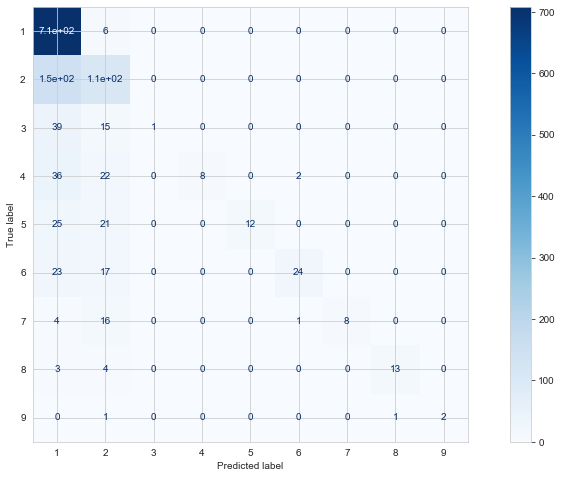

In [4]:
fig, ax = plt.subplots(figsize=(15, 8))
plot_confusion_matrix(etc, x, y,labels = np.arange(1,10),cmap =plt.cm.Blues,ax=ax)  # doctest: +SKIP
fig.show()

Some observations which we can make from the confusion matrix:
* The model is very accurate for class label 1
* The model also gets quite confused between labels 1,2,3 and 4.
* As the labels go higher the model also becomes a little more accurate for labels 8 aand 9
* From the confusion matrix,we can see the actual accuracy of the model is quite low, 
but as the ROC_AUC score is quite high ,we can say that probability of the true label is high for any prediction
* This also works out for our model because definite accuracy isnt necessary for predicting if a movies is succesful or not, instead the probability of the model predicting the movie is succesful should be high which it accurately shows

## Ranking Model Features Importance

[Text(0.5, 1.0, 'Feature Importance')]

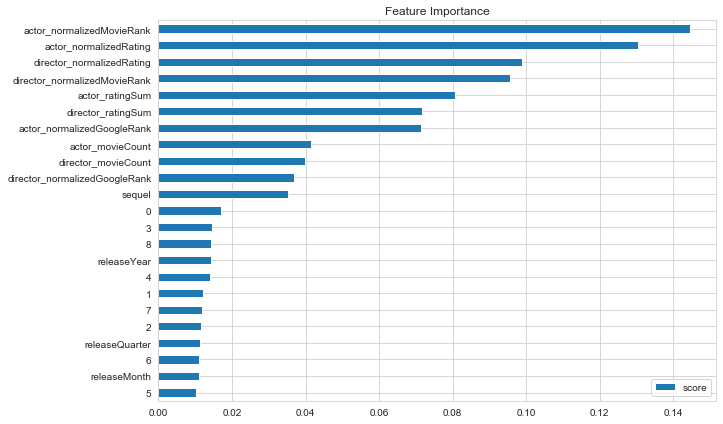

In [11]:
a  =etc.feature_importances_
b = x.columns
data = pd.DataFrame(a,index =b,columns =['score']).sort_values(by = 'score',ascending=True)
fig,ax = plt.subplots(figsize=(10,7))
data.plot(kind='barh',ax=ax)
ax.set(title = 'Feature Importance')

## Making a prediction system

Making predictions for new data given in form of the input dataset

In [23]:
#Loading pca and le models from previous notebooks
import pickle
with open('pca_model.pkl', 'rb') as file:  
    pca = pickle.load(file)
with open('le_model.pkl', 'rb') as file:  
    le = pickle.load(file)    

In [15]:
movie_details = pd.read_csv('data/raw/BollywoodMovieDetail.csv')
actors = pd.read_csv('data/raw/BollywoodActorRanking.csv')
directors = pd.read_csv('data/raw/BollywoodDirectorRanking.csv')

In [132]:
def preprocess(data1):
    data = data1.reset_index(drop=True)
    #Other columns
    train = data.drop(['imdbId','writers','title'],axis=1)
    train['releaseDate'] = pd.to_datetime(train['releaseDate'])
    train['releaseMonth'] = train['releaseDate'].apply(lambda x:x.month)
    train['sequel'] = train['sequel']
    train['releaseQuarter'] = train['releaseDate'].apply(lambda x:x.quarter)
    
    # Genre columns
    a = pd.DataFrame(data['genre'].apply(lambda x:x.split(' | ')[0]))
    a['genre2'] = data['genre'].apply(lambda x:'NA' if len(x.split(' | '))==1 else x.split(' | ')[1])
    a['genre3'] = data['genre'].apply(lambda x:'NA' if len(x.split(' | '))<3 else x.split(' | ')[2])
    cols = ['Drama', 'Comedy', 'Romance', 'Action', 'Crime', 'Thriller', 'Musical',
           'Mystery', 'Horror', 'Adventure', 'Family']
    for i in cols:
        train['genre_'+i]=0
    train['genre_other']=0
    for i in np.array(a.index):
        for j in cols:
            for k in ['genre','genre2','genre3']:
                if a.loc[i,k]==j:
                    train.loc[i,'genre_'+j]+=1
    for i in np.array(a.index):
        for k in ['genre','genre2','genre3']:
            if (a.loc[i,k] not in cols) & (a.loc[i,k]!='NA'):
                train.loc[i,'genre_other']+=1

    cols = ['genre_Drama','genre_Comedy', 'genre_Romance', 'genre_Action',
           'genre_Crime', 'genre_Thriller', 'genre_Musical', 'genre_Mystery',
           'genre_Horror', 'genre_Adventure', 'genre_Family', 'genre_other']
    pca_train = pd.DataFrame(pca.transform(train[cols]))
    train2 = pd.merge(train,pca_train,left_index=True,right_index=True)
    train2 = train2.drop(cols1,axis=1)
    
    #actors columns
    a = pd.DataFrame(data['actors'].apply(lambda x:x.split(' | ')[0]))
    a['actor2'] = data['actors'].apply(lambda x:x.split(' | ')[1])
    a['actor3'] = data['actors'].apply(lambda x:x.split(' | ')[2])
    a['actor4'] = data['actors'].apply(lambda x:x.split(' | ')[3])
    train2['actor_movieCount'] = 0
    train2['actor_ratingSum']=0
    train2['actor_normalizedMovieRank']=0
    train2['actor_normalizedGoogleRank']=0
    train2['actor_normalizedRating']=0

    for i in np.array(a.index):
        for j in actors['actorName']:
            for k in ['actors','actor2','actor3','actor4']:
                if a.loc[i,k]==j:
                    train2.loc[i,'actor_movieCount']+=np.array(actors.loc[actors['actorName']==j,'movieCount'])
                    train2.loc[i,'actor_ratingSum']+=np.array(actors.loc[actors['actorName']==j,'ratingSum'])
                    train2.loc[i,'actor_normalizedMovieRank']+=np.array(actors.loc[actors['actorName']==j,'normalizedMovieRank'])
                    train2.loc[i,'actor_normalizedGoogleRank']+=np.array(actors.loc[actors['actorName']==j,'normalizedGoogleRank'])
                    train2.loc[i,'actor_normalizedRating']+=np.array(actors.loc[actors['actorName']==j,'normalizedRating'])
    #directors column
    a = pd.DataFrame(data['directors'].apply(lambda x:x.split(' | ')[0]))
    a['director2'] = data['directors'].apply(lambda x:'NA' if len(x.split(' | '))==1 else x.split(' | ')[1])

    train2['director_movieCount'] = 0
    train2['director_ratingSum']=0
    train2['director_normalizedMovieRank']=0
    train2['director_normalizedGoogleRank']=0
    train2['director_normalizedRating']=0

    for i in np.array(a.index):
        for j in directors['directorName']:
            for k in ['directors','director2']:
                if a.loc[i,k]==j:
                    train2.loc[i,'director_movieCount']+=np.array(directors.loc[directors['directorName']==j,'movieCount'])
                    train2.loc[i,'director_ratingSum']+=np.array(directors.loc[directors['directorName']==j,'ratingSum'])
                    train2.loc[i,'director_normalizedMovieRank']+=np.array(directors.loc[directors['directorName']==j,'normalizedMovieRank'])
                    train2.loc[i,'director_normalizedGoogleRank']+=np.array(directors.loc[directors['directorName']==j,'normalizedGoogleRank'])
                    train2.loc[i,'director_normalizedRating']+=np.array(directors.loc[directors['directorName']==j,'normalizedRating'])
    train2 = train2.drop(['releaseDate','genre','actors','directors'],axis=1)  
    train2[['releaseYear','sequel']] = train2[['releaseYear','sequel']].apply(pd.to_numeric)
    train2['releaseYear'] = le.transform(train['releaseYear'])
    train2= train2.fillna(0)
    return train2                

### Making a sample prediction

In [145]:
#Example Prediction
cols = ['imdbId', 'title', 'releaseYear', 'releaseDate', 'genre', 'writers',
       'actors', 'directors', 'sequel']
a = ['trd','Imaginary Movie',2014, '12 Aug 2014','Drama | Adventure | Thriller','afd','Akshay Kumar | Aamir Khan | Shahrukh Khan | Amitabh Bachchan','Rajkumar Hirani',0 ]
data = pd.DataFrame(a,index =cols).T
etc.predict_proba(preprocess(data))

array([[0.05324428, 0.14920888, 0.04392645, 0.08495088, 0.14347742,
        0.1880368 , 0.08733849, 0.10934871, 0.14046808]])

In the above cell I made an imaginary movie containing top actors and top directors ,but still the model predicted it to be of class label 6.But after seeign the prediction probability values ,we can see that the probability for class 9 is not far behind.

So seeing the probability values,we can make a fairly accurate guess about the success of the movie

## Final Observations

Some final observations we can make:
1. Based on the feature importances,we can say that the most important features are the actors and directors movie rank and rating. This means that the presence of actors and directors who have made succesful movies in the past determines if this movie will be a success or not
2. Actor and director google rank are lower in the list. This means that the past success of cast is more important than their popularity.
3. Sequel movies are generally more succesfull as compared to one-off movies.
4. As the success of movies is adjusted with inflation of their box office earnings, the release year and month doesnt play a huge factor

## Actions which can be taken to improve the model accuracy

1. Introduce more data from higher classes so as to make the distribution less skewed.
2. As the success of actors and directors change over the years, introducing another feature which maps the current success in that specific year maybe useful
3. Also introducing more movies from the year 2015 to the current year can improve model accuracy.